In [1]:
import h5py
import numpy as np
import tensorflow.keras as keras
import sys
import pandas as pd

## Keras Generator in Action
So the generator was fun to call `next` on and print some data but how would we use in training a real ANN?(and I say real loosely) Well this example has got you covered. We are going to pretend the other example doesn't exist and do everything in this book. So first we need to read in our data, split it up, preprocess it and store it on disk as an hdf5 file.

## Pre-Processing
First read in the data from the text files

In [2]:
features = pd.read_csv('/opt/data/MagData/EE699_IN.txt').values
output = pd.read_csv('/opt/data/MagData/EE699_Out.txt').values

Now split into train and valid (we can do a test set later if we really want to but we don't really need one because we are not going to be publishing this)

In [3]:
all_data = np.concatenate([features, output], axis=1)
print(all_data[0,:])
np.random.shuffle(all_data)
print(all_data[0,:])
# I printed the first line before and after the shuffle to show that the data got shuffled

split = 0.7 # use a given split percentage where this number will be the training percentage
features_train = all_data[:int(all_data.shape[0]*split),:-1]
features_valid = all_data[int(all_data.shape[0]*split):,:-1]
output_train = all_data[:int(all_data.shape[0]*split),-1:]
output_valid = all_data[int(all_data.shape[0]*split):,-1:]

print(features_train.shape)
print(features_valid.shape)
print(output_train.shape)
print(output_valid.shape)

[  -0.36436   -0.2386     0.90017    0.7833    -0.29378 -112.69   ]
[ 9.5137e-01 -4.7304e-03  3.0801e-01 -1.0315e-01 -4.6876e-01 -1.2102e+03]
(7000, 5)
(3000, 5)
(7000, 1)
(3000, 1)


Next we will normalize the data to zero mean variance of one.

In [4]:
x_bias = np.mean(features_train, axis=0)
y_bias = np.mean(output_train, axis=0)

x_scale = np.std(features_train - x_bias, axis=0)
y_scale = np.std(output_train - y_bias, axis=0)

features_train_og = features_train
features_valid_og = features_valid
output_train_og = output_train
output_valid_og = output_valid

features_train = (features_train - x_bias) / x_scale
features_valid = (features_valid - x_bias) / x_scale
output_train = (output_train - y_bias) / y_scale
output_valid = (output_valid - y_bias) / y_scale

print("Mean of each feature:\n {0}".format(np.mean(features_train, axis=0)))
print("Standard deviation of each feature:\n {0}".format(np.std(features_train, axis=0)))

Mean of each feature:
 [ 2.99443010e-17 -3.24819536e-17  9.23705556e-17 -3.24819536e-17
  2.13162821e-17]
Standard deviation of each feature:
 [1. 1. 1. 1. 1.]


Great now we will store the `ndarray`s as h5 files so that we can access then from any line we want from disk

In [5]:
filename = "/opt/data/MagData/EE699_dat_action.h5"
with h5py.File(filename, 'w') as h5file:
    h5file.create_dataset(name='magdata/train/input', data=features_train)
    h5file.create_dataset(name='magdata/train/output', data=output_train)
    
    h5file.create_dataset(name='magdata/valid/input', data=features_valid)
    h5file.create_dataset(name='magdata/valid/output', data=output_valid)

## The Generator Function
Now we will make the generator function just like we did in the last notebook

In [6]:
def HDF5Generator(hdf5_path,
                  n_batches, 
                  hdf5XGroupName='train_set_x', 
                  hdf5YGroupName="train_set_y",
                  batch_size=100):
    """ Makes a generator function that pulls random batches of data from and hdf5 file

    :param hdf5_path: The path to the hdf5 file
    :param n_batches: number of batches in the file
    :param batch_size: the size of each batch
    :param hdf5XGroupName: the path to the dataset for the features, X, or input data
    :param hdf5YGroupName: the path to the dataset for the output targets

    :return: a generator that yields batches of data from an hdf5 file
    """
    trainIndices = list(range(n_batches))
    with h5py.File(name=hdf5_path, mode='r') as f:
        while True:
            np.random.shuffle(trainIndices)
            for batch_idx in trainIndices:
                startIdx = batch_idx * batch_size
                endIdx = (batch_idx + 1) * batch_size
                trainXbatch = f[hdf5XGroupName][startIdx:endIdx]
                trainYbatch = f[hdf5YGroupName][startIdx:endIdx]
                yield (trainXbatch, trainYbatch)

Now we can create the actual generators from these functions

In [7]:
train_gen = HDF5Generator(filename, 
                          n_batches=int(split*100), 
                          batch_size= 100, 
                          hdf5XGroupName='magdata/train/input', 
                          hdf5YGroupName='magdata/train/output')
valid_gen = HDF5Generator(filename, 
                          n_batches=int((1.-split)*100), 
                          batch_size= 100, 
                          hdf5XGroupName='magdata/valid/input', 
                          hdf5YGroupName='magdata/valid/output')

## Build the ANN
Now we can actually build our ANN

In [8]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.losses
metrics = ['mae']
last_layer_activation = 'linear'
optimizer = RMSprop(learning_rate=0.001)
loss_fn = keras.losses.mse

feature_size = features.shape[1]
output_size = output.shape[1]
layer_size = 20
n_epochs = 100

input_tensor = Input(shape=(feature_size,))

current_output = Dense(units=layer_size, activation='relu')(input_tensor)
current_output = Dense(units=output_size, activation=last_layer_activation)(current_output)

model = Model(inputs=input_tensor, outputs=current_output)

model.compile(loss=loss_fn, metrics=metrics, optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


Finally we will train the ANN using our newly created generators. To do this we will use the `fit_generator` function which expects a generator and not our actual data. Note this new `steps_per_epoch` variable we have to give. Since our generator will make data forever we need to actaully call out how many batches we want to do in one epoch. Same with the validation data. 

In [9]:
model.fit(train_gen, 
            steps_per_epoch=int(split*100), 
            epochs=n_epochs,
            validation_data=valid_gen,
            validation_steps=int((1.-split)*100))

Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.8140 - mae: 0.6619 - val_loss: 0.3644 - val_mae: 0.4434
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.2007 - mae: 0.3200 - val_loss: 0.0829 - val_mae: 0.2153
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0450 - mae: 0.1570 - val_loss: 0.0204 - val_mae: 0.1113
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0111 - mae: 0.0804 - val_loss: 0.0055 - val_mae: 0.0586
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0043 - mae: 0.0518 - val_loss: 0.0033 - val_mae: 0.0459
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0432 - val_loss: 0.0025 - val_mae: 0.0393
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0368 - val_loss: 0.0018 - val_mae: 0.0341
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0016 - m

70/70 [==============================] - 0s 2ms/step - loss: 1.9322e-04 - mae: 0.0109 - val_loss: 2.1102e-04 - val_mae: 0.0114
Epoch 61/100
70/70 [==============================] - 0s 2ms/step - loss: 1.9411e-04 - mae: 0.0110 - val_loss: 1.8752e-04 - val_mae: 0.0107
Epoch 62/100
70/70 [==============================] - 0s 2ms/step - loss: 1.8910e-04 - mae: 0.0109 - val_loss: 2.2154e-04 - val_mae: 0.0117
Epoch 63/100
70/70 [==============================] - 0s 2ms/step - loss: 1.9692e-04 - mae: 0.0111 - val_loss: 2.1146e-04 - val_mae: 0.0114
Epoch 64/100
70/70 [==============================] - 0s 2ms/step - loss: 1.8796e-04 - mae: 0.0108 - val_loss: 2.2236e-04 - val_mae: 0.0122
Epoch 65/100
70/70 [==============================] - 0s 2ms/step - loss: 1.9175e-04 - mae: 0.0109 - val_loss: 1.6534e-04 - val_mae: 0.0101
Epoch 66/100
70/70 [==============================] - 0s 2ms/step - loss: 1.8858e-04 - mae: 0.0108 - val_loss: 2.6170e-04 - val_mae: 0.0129
Epoch 67/100
70/70 [=============

## Examine our Output
In order to actually get an idea of our error metrics we should look at them in the unscaled domain (before we normalized our data). To do this we will multiply the error by the scaling factor. 

In [10]:
predictions_train = model.predict(features_train)
predictions_train_unscaled = (predictions_train * y_scale) - y_bias
mae_train = np.mean(np.abs((output_train_og - predictions_train_unscaled)))

predictions_valid = model.predict(features_valid)
predictions_valid_unscaled = (predictions_valid * y_scale) - y_bias
mae_valid = np.mean(np.abs((output_valid_og - predictions_valid_unscaled)))
(mae_train, mae_valid)

(19.402016449079117, 20.130922057529023)

I guess those are good numbers but maybe we should visualize them to get a better idea if this is good or not

## Visualize
Usually I like to see the data visually. Here is a simple idea how about I plot the truth as green dots and the predictions as red ones. I guess I have to spread these out over the x axis or else they will just be all jumbled on top of each other.

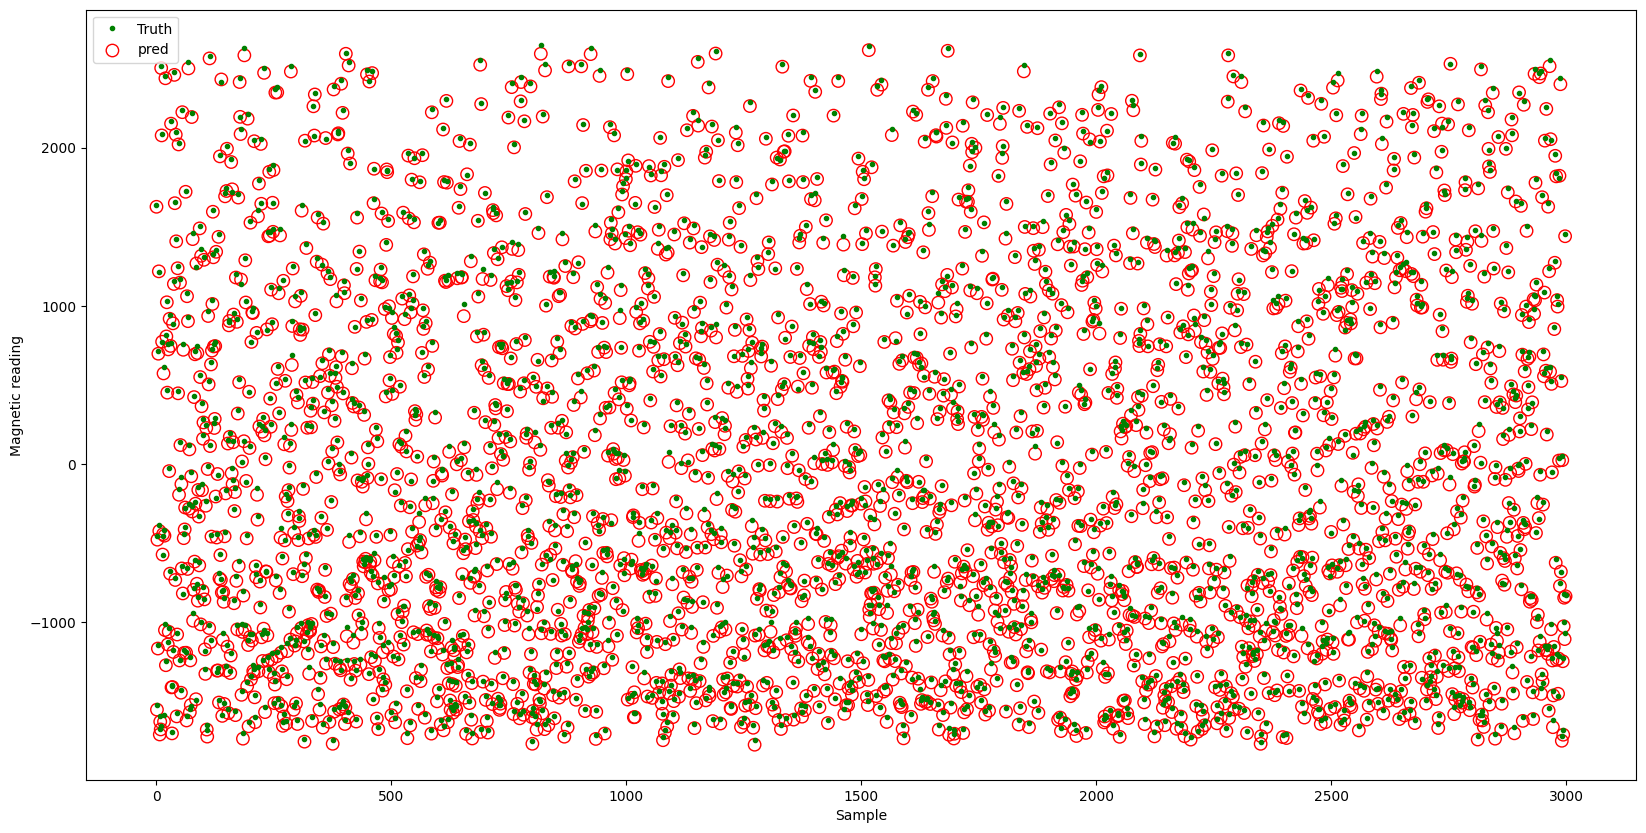

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(output_valid_og, 'g.', label='Truth')
plt.scatter(range(predictions_valid_unscaled.shape[0]), predictions_valid_unscaled,
            s=80, facecolors='none', edgecolors='r', label='pred')

plt.ylabel('Magnetic reading')
plt.xlabel('Sample')
plt.legend()
plt.show()

The looks pretty good I guess. Most of the green dots are in the red circles. But I don't like how the x axis doesn't have a lot of meaning.

How about we plot the truth on one axis and the prediction on the other. If its good it should be a 45 degree line.

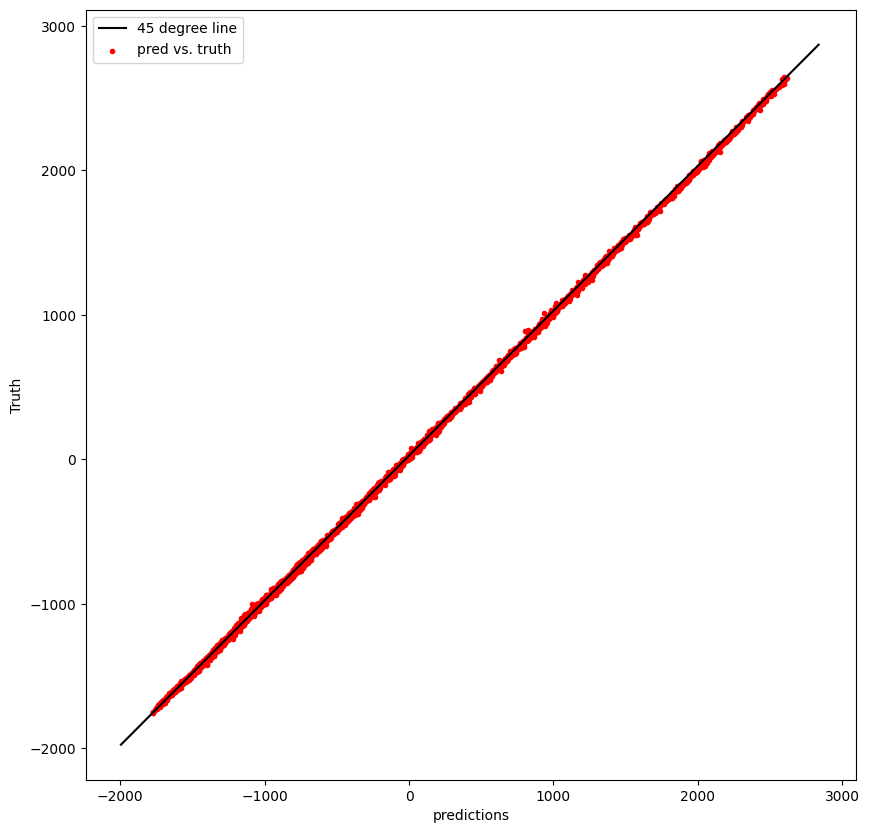

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(predictions_valid_unscaled, output_valid_og, c='r', marker='.', label='pred vs. truth')
plt.xlabel('predictions')
plt.ylabel('Truth')
# overlay the 45 degree line
plt.plot(plt.xlim(), plt.ylim(), 'k', label='45 degree line')
plt.axis('square')
plt.legend()
plt.show()

That looks much better. Our samples in red closely follow the black line and now both axes have meaning.

## Histograms and Cumulative Distribution plots
We may also want to look at the error distributions instead of the whole values. First lets look at the median and the mean

In [13]:
maerror = np.abs(predictions_valid_unscaled- output_valid_og)
print(f"MAE Median: {np.percentile(maerror, 50)}")
print(f"MAE Mean: {maerror.mean()}")

MAE Median: 19.807259872049656
MAE Mean: 20.130922057529023


Now how about we look at the entire histogram and cumulative histogram

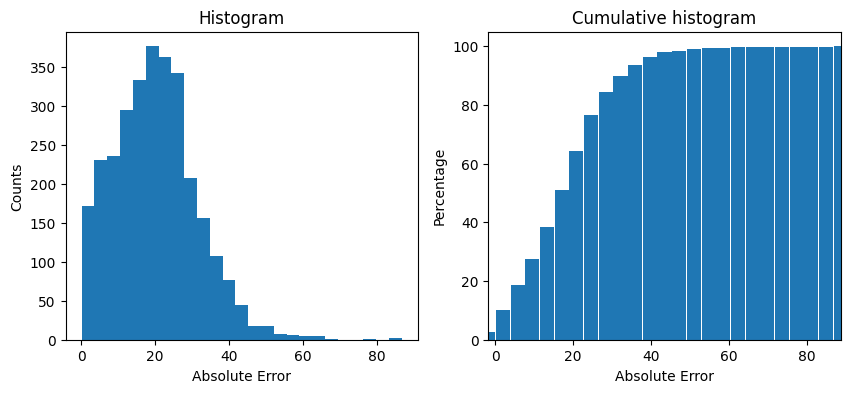

In [14]:
import scipy.stats
res = scipy.stats.cumfreq(maerror, numbins=25)
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(maerror, bins=25)
ax1.set_title('Histogram')
ax1.set_xlabel('Absolute Error')
ax1.set_ylabel('Counts')
ax2.bar(x, res.cumcount/res.cumcount.max() * 100, width=res.binsize)
ax2.set_title('Cumulative histogram')
ax2.set_xlim([x.min(), x.max()])
ax2.set_xlabel('Absolute Error')
ax2.set_ylabel('Percentage')
plt.show()

This is much more descriptive of our errors compared to single values.

So I used the term ANN loosely because this is a really easy problem to solve even with a 1 layer ANN.

# Multiprocessing Generators
Sometimes your generator can be slow to make a new batch. In this case it wastes GPU time if the program waits for the the next batch and does nothing on the GPU. 

If we use multiprocessing we can make multiple batches in parallel. The batches are then put in a queue for the training function. In this way as long as something is on the queue we will not waste GPU time

In [15]:
train_gen = HDF5Generator(filename, 
                          n_batches=int(split*100), 
                          batch_size= 100, 
                          hdf5XGroupName='magdata/train/input', 
                          hdf5YGroupName='magdata/train/output')
valid_gen = HDF5Generator(filename, 
                          n_batches=int((1.-split)*100), 
                          batch_size= 100, 
                          hdf5XGroupName='magdata/valid/input', 
                          hdf5YGroupName='magdata/valid/output')

In [16]:
input_tensor = Input(shape=(feature_size,))

current_output = Dense(units=layer_size, activation='relu')(input_tensor)
current_output = Dense(units=output_size, activation=last_layer_activation)(current_output)

model = Model(inputs=input_tensor, outputs=current_output)

model.compile(loss=loss_fn, metrics=metrics, optimizer=optimizer)
model.summary()

model.fit(train_gen, 
            steps_per_epoch=int(split*100), 
            epochs=n_epochs,
            validation_data=valid_gen,
            validation_steps=int((1.-split)*100),
            max_queue_size=50,
            workers=5,
            use_multiprocessing=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 20)                120       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
70/70 [==============================] - 1s 5ms/step - loss: 0.9951 - mae: 0.8030 - val_loss: 0.4951 - val_mae: 0.5880
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.2768 - mae: 0.4218 - val_loss: 0.0965 - val_mae: 0.2496
Epoch 3/100
70/70 [==============================] - 0s 4ms/ste

70/70 [==============================] - 0s 5ms/step - loss: 1.7763e-04 - mae: 0.0105 - val_loss: 1.6910e-04 - val_mae: 0.0102
Epoch 55/100
70/70 [==============================] - 0s 5ms/step - loss: 1.8692e-04 - mae: 0.0108 - val_loss: 1.4925e-04 - val_mae: 0.0096
Epoch 56/100
70/70 [==============================] - 0s 5ms/step - loss: 1.6837e-04 - mae: 0.0102 - val_loss: 2.0963e-04 - val_mae: 0.0116
Epoch 57/100
70/70 [==============================] - 0s 5ms/step - loss: 1.6631e-04 - mae: 0.0102 - val_loss: 2.7527e-04 - val_mae: 0.0134
Epoch 58/100
70/70 [==============================] - 0s 5ms/step - loss: 1.6274e-04 - mae: 0.0101 - val_loss: 2.1464e-04 - val_mae: 0.0115
Epoch 59/100
70/70 [==============================] - 0s 5ms/step - loss: 1.7521e-04 - mae: 0.0103 - val_loss: 1.6539e-04 - val_mae: 0.0101
Epoch 60/100
70/70 [==============================] - 0s 5ms/step - loss: 1.6068e-04 - mae: 0.0100 - val_loss: 1.3702e-04 - val_mae: 0.0092
Epoch 61/100
70/70 [=============

We can also use the evaluate funciton with a generator

In [18]:
model.evaluate(valid_gen, steps=100)

100/100 [==============================] - 0s 1ms/step - loss: 1.7595e-04 - mae: 0.0107


[0.00017594954988453537, 0.010732276365160942]

Remember these numbers are still the scaled versions so we cannot say much about it.